In [73]:
!pip install catboost
!pip install phik

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from matplotlib.colors import LinearSegmentedColormap
from phik import phik_matrix
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import roc_auc_score, confusion_matrix
from catboost import CatBoostClassifier, cv, Pool


color_palette = ['#AD4A2B', '#6A7B73', '#3D3E3B', '#E78F63', '#F7C7B1']
colors = ['#6A7B73', '#E78F63']
cmap = LinearSegmentedColormap.from_list("color_palette", colors, N=50)
sns.set(style="whitegrid", palette=color_palette)


train = pd.read_csv('/content/train.csv')
test = pd.read_csv('/content/test.csv')

numerical = [
    'ClientPeriod',
    'MonthlySpending',
    'TotalSpent'
]

categorical = [
    'Sex',
    'IsSeniorCitizen',
    'HasPartner',
    'HasChild',
    'HasPhoneService',
    'HasMultiplePhoneNumbers',
    'HasInternetService',
    'HasOnlineSecurityService',
    'HasOnlineBackup',
    'HasDeviceProtection',
    'HasTechSupportAccess',
    'HasOnlineTV',
    'HasMovieSubscription',
    'HasContractPhone',
    'IsBillingPaperless',
    'PaymentMethod'
]

X = numerical + categorical
y = 'Churn'

train.head()


,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


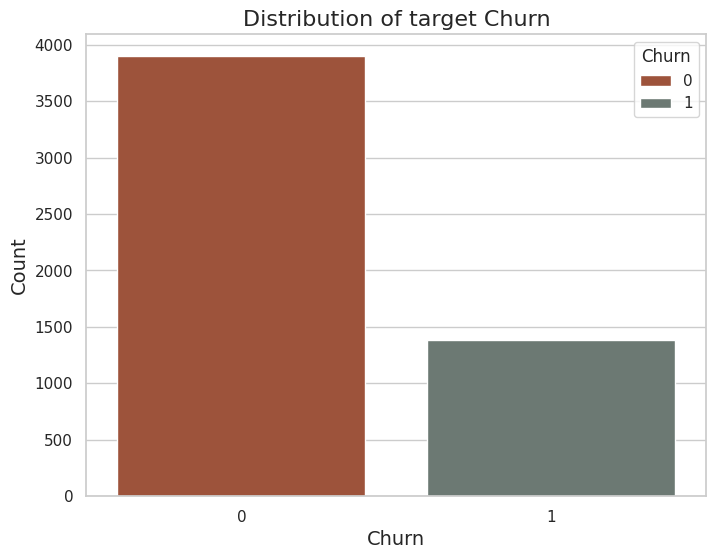

In [74]:
train[y].value_counts()
class_counts = train[y].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index)
plt.title(f'Distribution of target Churn', fontsize=16)
plt.xlabel(f'{y}', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

In [75]:
train[numerical].info()
test[numerical].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ClientPeriod     5282 non-null   int64  
 1   MonthlySpending  5282 non-null   float64
 2   TotalSpent       5282 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 123.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ClientPeriod     1761 non-null   int64  
 1   MonthlySpending  1761 non-null   float64
 2   TotalSpent       1761 non-null   object 
dtypes: float64(1), int64(1), object(1)
memory usage: 41.4+ KB


In [76]:
train['TotalSpent'] = train['TotalSpent'].replace(' ', None)
test['TotalSpent'] = test['TotalSpent'].replace(' ', None)
train['TotalSpent'] = train['TotalSpent'].astype(float)
test['TotalSpent'] = test['TotalSpent'].astype(float)
train[train['TotalSpent'].isna()]

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
1048,0,25.75,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
1707,0,73.35,NaN,Female,0,Yes,Yes,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,0
2543,0,19.70,NaN,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,0
3078,0,80.85,NaN,Female,0,Yes,Yes,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,0
3697,0,20.00,NaN,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4002,0,61.90,NaN,Male,0,No,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,No,No,Two year,Yes,Bank transfer (automatic),0
4326,0,25.35,NaN,Male,0,Yes,Yes,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,0
4551,0,52.55,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),0
4598,0,56.05,NaN,Female,0,Yes,Yes,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),0


In [77]:
train['TotalSpent'].fillna(0, inplace=True)
test['TotalSpent'].fillna(0, inplace=True)
train[numerical].describe()


,ClientPeriod,MonthlySpending,TotalSpent
count,5282.000000,5282.000000,5282.000000
mean,32.397009,64.924754,2287.486161
std,24.550326,30.176464,2269.049195
min,0.000000,18.250000,0.000000
25%,9.000000,35.462500,395.725000
50%,29.000000,70.400000,1405.650000
75%,55.000000,90.050000,3795.212500
max,72.000000,118.750000,8684.800000


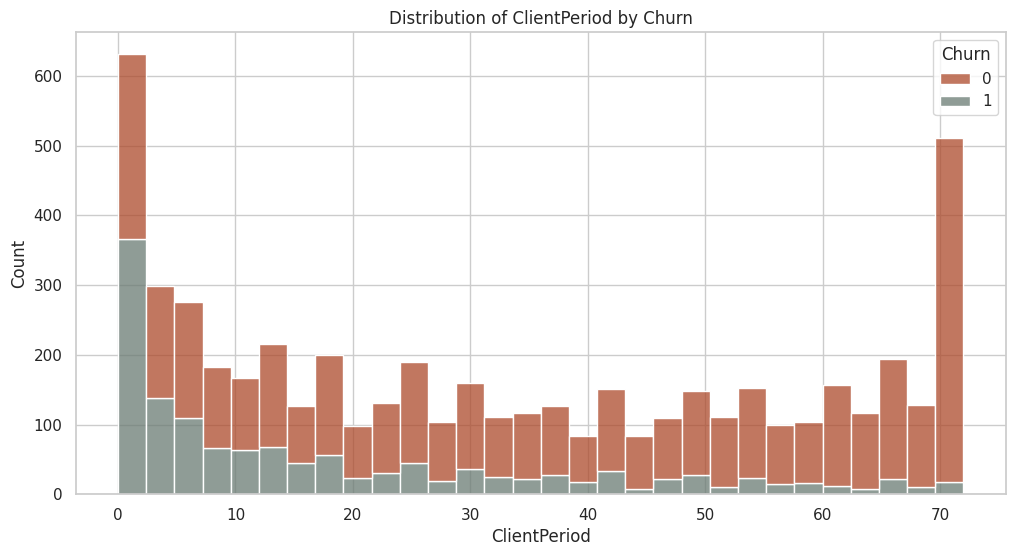

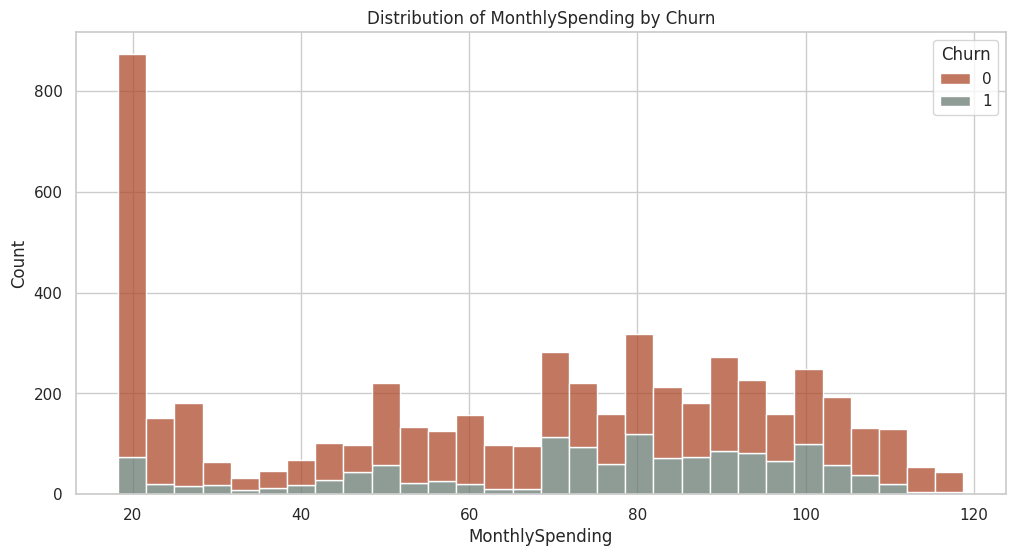

In [78]:
plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='ClientPeriod', hue='Churn', multiple='stack', bins=30)
plt.title('Distribution of ClientPeriod by Churn')
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data=train, x='MonthlySpending', hue='Churn', multiple='stack', bins=30)
plt.title('Distribution of MonthlySpending by Churn')
plt.show()

In [79]:
train[categorical].head()

,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check
1,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic)
2,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check
3,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check
4,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic)


In [80]:
train[categorical].info()
test[categorical].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Sex                       5282 non-null   object
 1   IsSeniorCitizen           5282 non-null   int64 
 2   HasPartner                5282 non-null   object
 3   HasChild                  5282 non-null   object
 4   HasPhoneService           5282 non-null   object
 5   HasMultiplePhoneNumbers   5282 non-null   object
 6   HasInternetService        5282 non-null   object
 7   HasOnlineSecurityService  5282 non-null   object
 8   HasOnlineBackup           5282 non-null   object
 9   HasDeviceProtection       5282 non-null   object
 10  HasTechSupportAccess      5282 non-null   object
 11  HasOnlineTV               5282 non-null   object
 12  HasMovieSubscription      5282 non-null   object
 13  HasContractPhone          5282 non-null   object
 14  IsBillingPaperless      

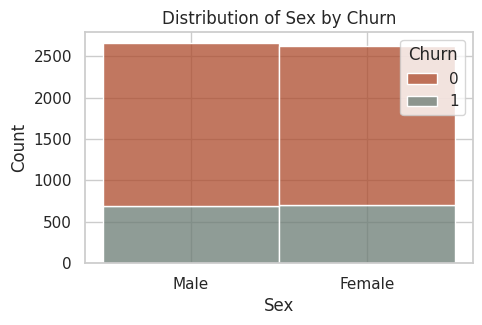

In [81]:
train['Sex'].value_counts(dropna=False)
test['Sex'].value_counts(dropna=False)
plt.figure(figsize=(5, 3))
sns.histplot(data=train, x='Sex', hue='Churn', multiple='stack', bins=30)
plt.title('Distribution of Sex by Churn')
plt.show()

In [82]:
print(train['IsSeniorCitizen'].value_counts(dropna=False))
print(test['IsSeniorCitizen'].value_counts(dropna=False))

IsSeniorCitizen
0    4440
1     842
Name: count, dtype: int64
IsSeniorCitizen
0    1461
1     300
Name: count, dtype: int64


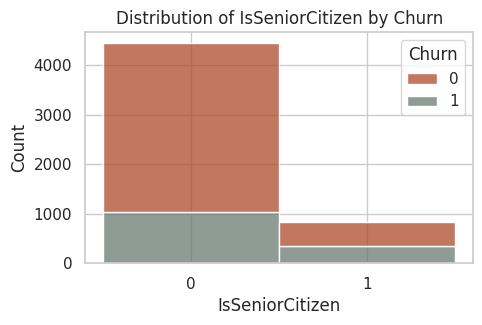

In [91]:
train['IsSeniorCitizen'] = train['IsSeniorCitizen'].astype('category')
test['IsSeniorCitizen'] = test['IsSeniorCitizen'].astype('category')
plt.figure(figsize=(5, 3))
sns.histplot(data=train, x='IsSeniorCitizen', hue='Churn', multiple='stack')
plt.title('Distribution of IsSeniorCitizen by Churn')
plt.xticks(ticks=[0, 1])
plt.show()

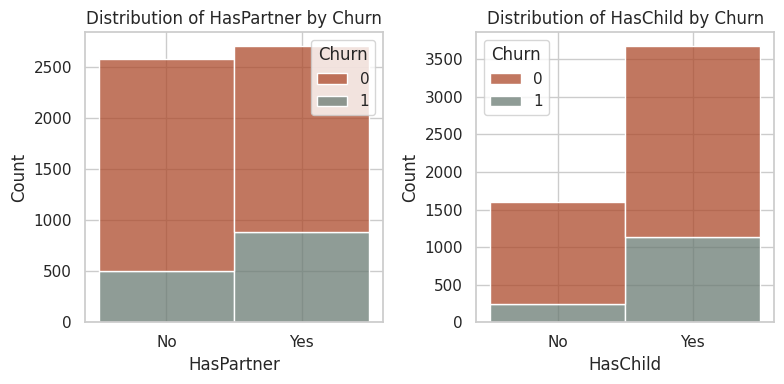

In [92]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(data=train, x='HasPartner', hue='Churn', multiple='stack', ax=axes[0])
axes[0].set_title('Distribution of HasPartner by Churn')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['No', 'Yes'])

sns.histplot(data=train, x='HasChild', hue='Churn', multiple='stack', ax=axes[1])
axes[1].set_title('Distribution of HasChild by Churn')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['No', 'Yes'])

plt.tight_layout()
plt.show()

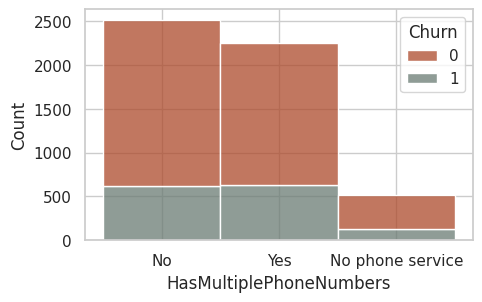

In [93]:
plt.figure(figsize=(5, 3))
sns.histplot(data=train, x='HasMultiplePhoneNumbers', hue='Churn', multiple='stack')
plt.show()

HasInternetService
Fiber optic    2341
DSL            1800
No             1141
Name: count, dtype: int64
HasOnlineSecurityService
No                     2612
Yes                    1529
No internet service    1141
Name: count, dtype: int64
HasOnlineBackup
No                     2332
Yes                    1809
No internet service    1141
Name: count, dtype: int64


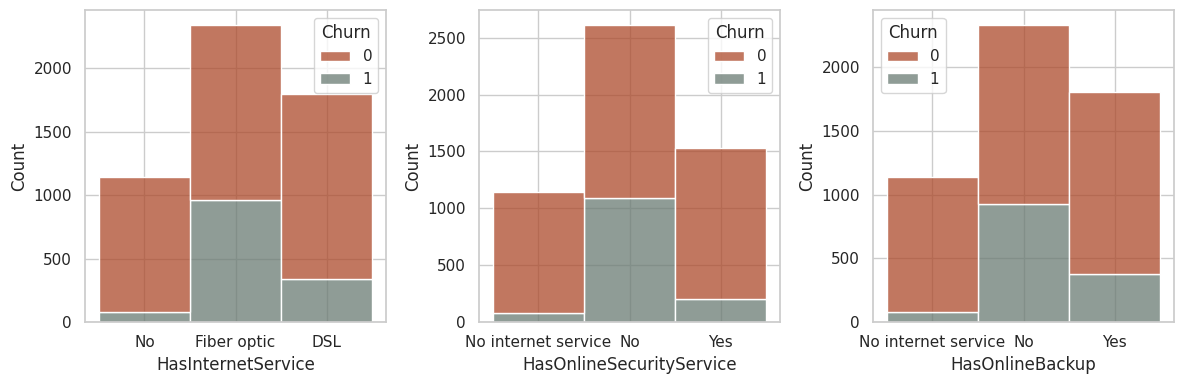

In [94]:
print(train['HasInternetService'].value_counts(dropna=False))
print(train['HasOnlineSecurityService'].value_counts(dropna=False))
print(train['HasOnlineBackup'].value_counts(dropna=False))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))

sns.histplot(data=train, x='HasInternetService', hue='Churn', multiple='stack', ax=axes[0])

sns.histplot(data=train, x='HasOnlineSecurityService', hue='Churn', multiple='stack', ax=axes[1])

sns.histplot(data=train, x='HasOnlineBackup', hue='Churn', multiple='stack', ax=axes[2])

plt.tight_layout()

plt.show()

HasDeviceProtection
No                     2317
Yes                    1824
No internet service    1141
Name: count, dtype: int64
HasDeviceProtection
No                     778
Yes                    598
No internet service    385
Name: count, dtype: int64
HasTechSupportAccess
No                     2604
Yes                    1537
No internet service    1141
Name: count, dtype: int64
HasTechSupportAccess
No                     869
Yes                    507
No internet service    385
Name: count, dtype: int64


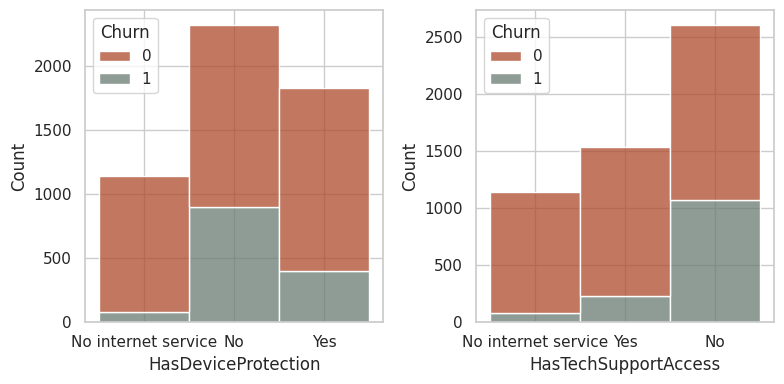

In [96]:
print(train['HasDeviceProtection'].value_counts(dropna=False))
print(test['HasDeviceProtection'].value_counts(dropna=False))
print(train['HasTechSupportAccess'].value_counts(dropna=False))
print(test['HasTechSupportAccess'].value_counts(dropna=False))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(data=train, x='HasDeviceProtection', hue='Churn', multiple='stack', ax=axes[0])

sns.histplot(data=train, x='HasTechSupportAccess', hue='Churn', multiple='stack', ax=axes[1])

plt.tight_layout()
plt.show()

HasOnlineTV
No                     2099
Yes                    2042
No internet service    1141
Name: count, dtype: int64
HasMovieSubscription
No                     2081
Yes                    2060
No internet service    1141
Name: count, dtype: int64


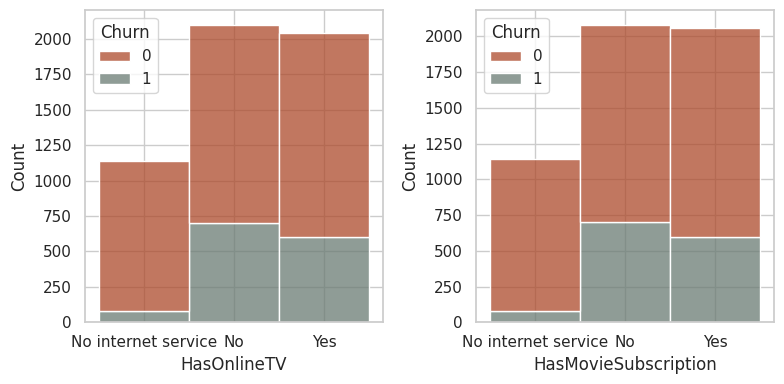

In [97]:
print(train['HasOnlineTV'].value_counts(dropna=False))
print(train['HasMovieSubscription'].value_counts(dropna=False))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(data=train, x='HasOnlineTV', hue='Churn', multiple='stack', ax=axes[0])

sns.histplot(data=train, x='HasMovieSubscription', hue='Churn', multiple='stack', ax=axes[1])

plt.tight_layout()
plt.show()

In [98]:
train.columns

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'Churn'],
      dtype='object')

HasContractPhone
Month-to-month    2920
Two year          1280
One year          1082
Name: count, dtype: int64
IsBillingPaperless
Yes    3148
No     2134
Name: count, dtype: int64


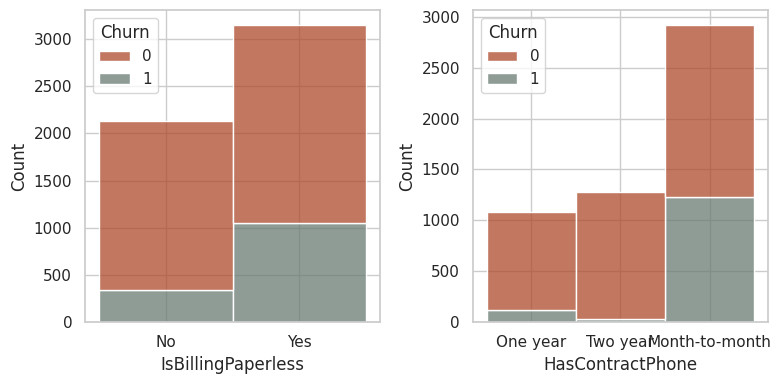

In [99]:
print(train['HasContractPhone'].value_counts(dropna=False))
print(train['IsBillingPaperless'].value_counts(dropna=False))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

sns.histplot(data=train, x='IsBillingPaperless', hue='Churn', multiple='stack', ax=axes[0])

sns.histplot(data=train, x='HasContractPhone', hue='Churn', multiple='stack', ax=axes[1])

plt.tight_layout()
plt.show()

PaymentMethod
Electronic check             1786
Mailed check                 1194
Bank transfer (automatic)    1159
Credit card (automatic)      1143
Name: count, dtype: int64


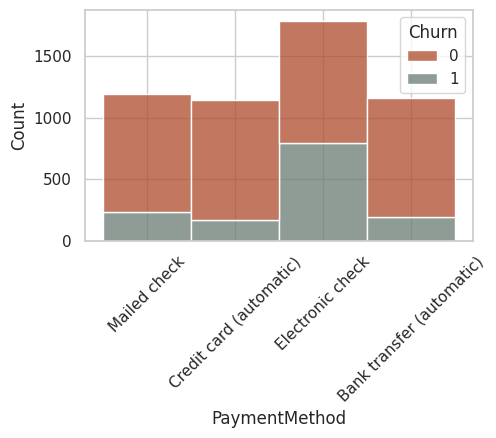

In [100]:
print(train['PaymentMethod'].value_counts(dropna=False))
plt.figure(figsize=(5, 3))
sns.histplot(data=train, x='PaymentMethod', hue='Churn', multiple='stack')
plt.xticks(rotation=45)
plt.show()

interval columns not set, guessing: ['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Churn']


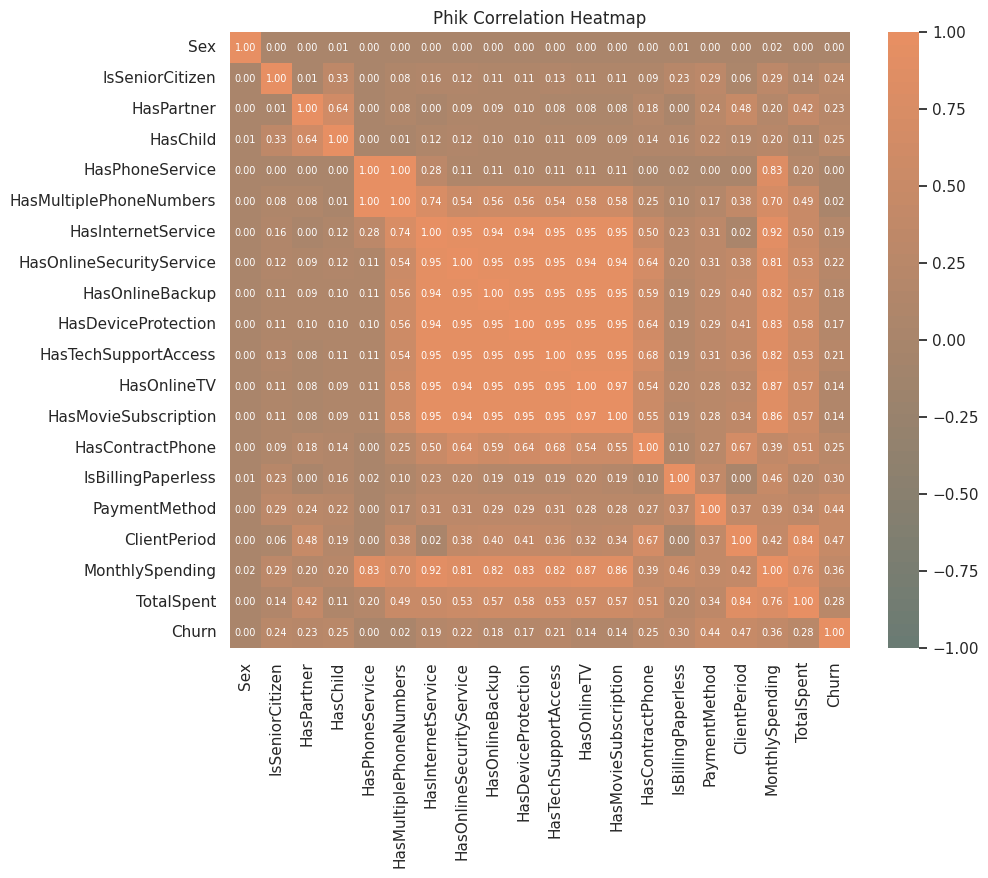

In [102]:
phik_corr = train[categorical + numerical + [y]].phik_matrix()

plt.figure(figsize=(10, 8))
sns.heatmap(
    phik_corr,
    annot=True,
    cmap=cmap,
    fmt=".2f",
    vmin=-1,
    vmax=1,
    annot_kws={"size": 7}
)
plt.title('Phik Correlation Heatmap')
plt.show()

In [103]:
X = categorical + numerical
columns_to_replace = [
    'HasOnlineSecurityService', 'HasOnlineBackup',
    'HasDeviceProtection', 'HasTechSupportAccess',
    'HasOnlineTV', 'HasMovieSubscription'
]

# Заменяем "No internet service" на "No"
for col in columns_to_replace:
    train[col] = train[col].replace('No internet service', 'No')
    test[col] = test[col].replace('No internet service', 'No')

train.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No,No,No,No,No,No,One year,No,Mailed check,0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No,No,No,No,No,No,Two year,No,Credit card (automatic),0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [104]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

X_train, X_valid, y_train, y_valid = train_test_split(train[X], train[y], test_size=0.2, random_state=42)

# Создаем трансформер для обработки данных
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical),  # Нормализация числовых признаков
        ('cat', OneHotEncoder(), categorical)  # Кодирование категориальных признаков
    ]
)

# Создаем полный пайплайн
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegressionCV())
])

# Настройка сеточного поиска
param_grid = [{'classifier': [LogisticRegressionCV()],
              'classifier__Cs': [100, 10, 1, 0.1, 0.01, 0.001]},
              {'classifier': [RandomForestClassifier(n_estimators=10)],
               'classifier__max_features': [1, 2, 3]},
              {'classifier': [DecisionTreeClassifier(random_state=0)],
                'classifier__max_depth': [1, 2, 3]},
              {'classifier': [GradientBoostingClassifier(random_state=0)],
                'classifier__max_depth': [1, 2, 3]},
              {'classifier': [MLPClassifier(random_state=0)]
                }
              ]

gs = GridSearchCV(estimator=pipeline,
                  param_grid=param_grid,
                  scoring='roc_auc',
                  n_jobs=-1,
                  cv=5,
                  verbose=1,
                  refit=True,
                  pre_dispatch='2*n_jobs')

# Запуск
gs.fit(X_train, y_train)
print('Best GS Score %.2f' % gs.best_score_)
print('best GS Params %s' % gs.best_params_)
print('best score test %s' % gs.score(X_valid,y_valid))

# Предсказание на тренировочном наборе
y_pred = gs.predict(X_train)
train_acc = (y_train == y_pred).sum()/len(y_train)
print('\nTrain Accuracy: %.2f' % (train_acc))

# Оценка на тестовом наборе
y_pred_val = gs.predict(X_valid)
# Вычисляем ROC-AUC
roc_auc = roc_auc_score(y_valid, y_pred_val)
print(f'ROC-AUC: {roc_auc:.4f}')
test_acc = (y_valid == y_pred_val).sum()/len(y_valid)
print('\nTest Accuracy: %.2f' % (test_acc))


Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best GS Score 0.85
best GS Params {'classifier': GradientBoostingClassifier(random_state=0), 'classifier__max_depth': 2}
best score test 0.8274097025332239

Train Accuracy: 0.83
ROC-AUC: 0.6739

Test Accuracy: 0.78


In [105]:
X_train, X_valid, y_train, y_valid = train_test_split(train[X], train[y], test_size=0.2, random_state=42)

catboost = CatBoostClassifier(cat_features=categorical, eval_metric='AUC', random_state=42, verbose=300)

catboost.fit(X_train, y_train, eval_set=(X_valid, y_valid))

# Получаем вероятности для ROC-AUC
y_pred_prob = catboost.predict_proba(X_valid)[:, 1]

# Вычисляем ROC-AUC
roc_auc = roc_auc_score(y_valid, y_pred_prob)
print(f'ROC-AUC: {roc_auc:.4f}')

Learning rate set to 0.045236
0:	test: 0.7247532	best: 0.7247532 (0)	total: 10.8ms	remaining: 10.8s
300:	test: 0.8250801	best: 0.8294807 (181)	total: 2.91s	remaining: 6.76s
600:	test: 0.8171032	best: 0.8294807 (181)	total: 7.13s	remaining: 4.73s
900:	test: 0.8158172	best: 0.8294807 (181)	total: 9.82s	remaining: 1.08s
999:	test: 0.8146074	best: 0.8294807 (181)	total: 10.7s	remaining: 0us

bestTest = 0.829480703
bestIteration = 181

Shrink model to first 182 iterations.
ROC-AUC: 0.8295
